In [2]:
from ultralytics import YOLO
import cv2 as cv
from PIL import Image

In [69]:
image_path = ["HCM_traffic/tracking_data/images/cam_01/cam_01_000000.jpg",
             "HCM_traffic/tracking_data/images/cam_01/cam_01_000002.jpg"]

In [70]:

# Load a model
model = YOLO("runs/detect/train/weights/best.pt")  # pretrained YOLO11n model

# Run batched inference on a list of images
results = model.predict(image_path)


0: 384x640 6 motorbikes, 5 cars, 3 trucks, 5.0ms
1: 384x640 3 motorbikes, 2 cars, 7 trucks, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


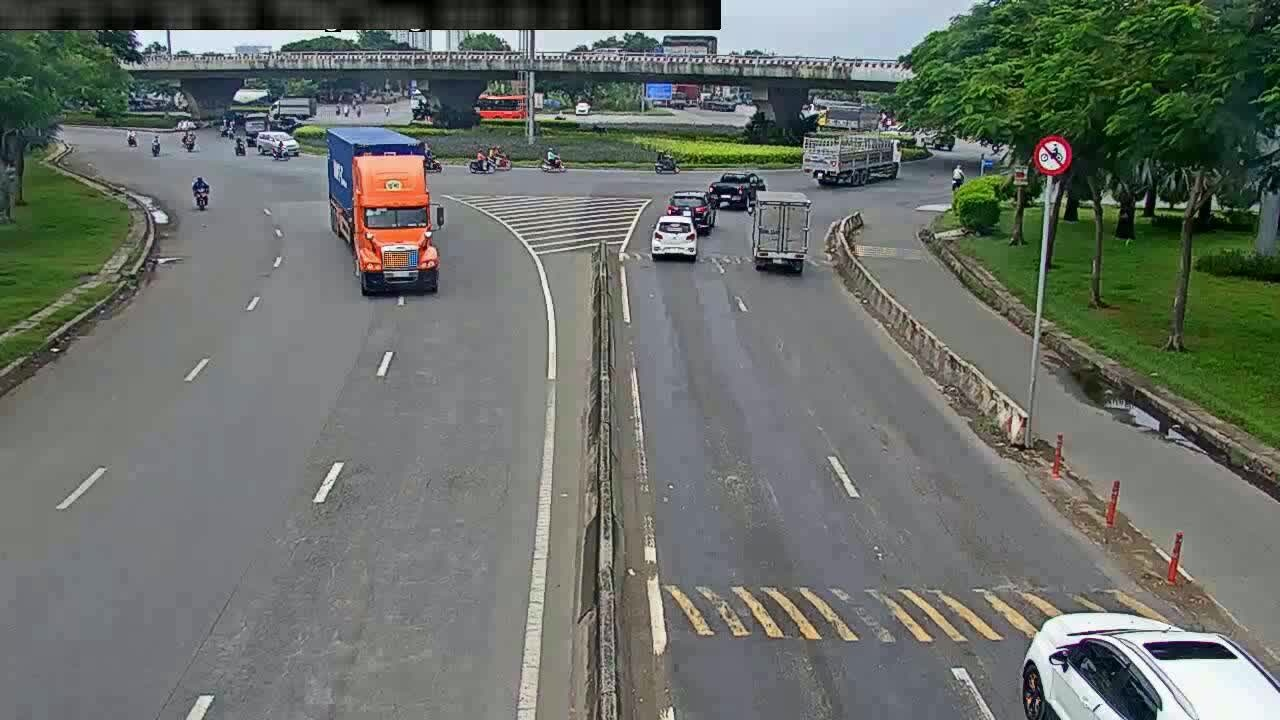

In [71]:
img = Image.open(image_path[0]).convert('RGB')
img

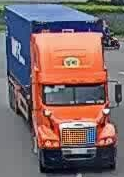

(124, 177)


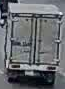

(65, 89)


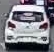

(54, 52)


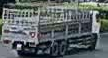

(108, 58)


(25, 39)


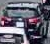

(50, 44)


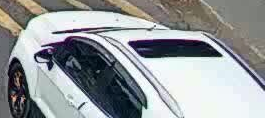

(265, 118)


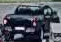

(61, 42)


(33, 28)


(31, 27)


(30, 27)


(50, 31)


(18, 30)


(27, 26)


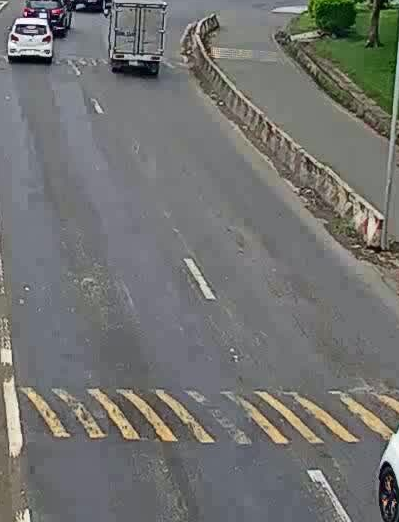

(399, 522)


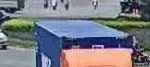

(150, 67)


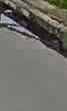

(67, 111)


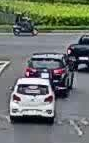

(89, 143)


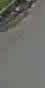

(45, 88)


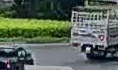

(118, 70)


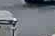

(55, 36)


(24, 41)


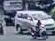

(55, 41)


(47, 31)


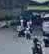

(49, 54)


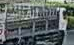

(74, 45)


In [72]:
instance_imgs_frames = []
for res in results:
    frames_obj_instances = []
    for d in res.boxes.xyxy:
        img.crop(d.tolist()).show()
        print(img.crop(d.tolist()).size)
        # frames_obj_instances.append(prep(img.crop(d.tolist())))
        frames_obj_instances.append(img.crop(d.tolist()))
    instance_imgs_frames.append(frames_obj_instances)

In [74]:
def track_objects_between_frames(frame1_objects, frame2_objects):
    """
    Track objects between two frames using ResNet embeddings and cosine similarity.
    
    Args:
        frame1_objects: List of M cropped object bounding boxes from frame 1 (PIL Images)
        frame2_objects: List of N cropped object bounding boxes from frame 2 (PIL Images)
        
    Returns:
        similarity_matrix: MxN matrix with cosine similarity scores
    """
    # 1. Load ResNet model
    resnet = models.resnet50(pretrained=True)
    # Remove the final classification layer
    resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
    resnet.eval()
    
    # 2. Define image transformations (same as ResNet training)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # 3. Extract embeddings for frame 1 objects
    frame1_embeddings = []
    for obj in frame1_objects:
        # Apply transformations
        img_tensor = transform(obj).unsqueeze(0)
        
        # Get embedding
        with torch.no_grad():
            embedding = resnet(img_tensor)
            
        # Flatten the embedding
        embedding = embedding.squeeze().flatten()
        frame1_embeddings.append(embedding)
    
    # 4. Extract embeddings for frame 2 objects
    frame2_embeddings = []
    for obj in frame2_objects:
        # Apply transformations
        img_tensor = transform(obj).unsqueeze(0)
        
        # Get embedding
        with torch.no_grad():
            embedding = resnet(img_tensor)
            
        # Flatten the embedding
        embedding = embedding.squeeze().flatten()
        frame2_embeddings.append(embedding)
    
    # 5. Compute cosine similarity between all pairs of objects
    M = len(frame1_objects)
    N = len(frame2_objects)
    similarity_matrix = torch.zeros((M, N))
    
    for i in range(M):
        for j in range(N):
            similarity_matrix[i, j] = cosine_similarity(
                frame1_embeddings[i].unsqueeze(0),
                frame2_embeddings[j].unsqueeze(0)
            )
    
    return similarity_matrix, frame1_objects, frame2_objects

def visualize_similarity_matrix_improved(similarity_matrix, frame1_objects, frame2_objects):
    """
    Visualize the similarity matrix with improved layout matching the example.
    
    Args:
        similarity_matrix: MxN torch tensor with cosine similarity scores
        frame1_objects: List of frame 1 objects (PIL Images)
        frame2_objects: List of frame 2 objects (PIL Images)
    """
    M = len(frame1_objects)
    N = len(frame2_objects)
    
    # Convert similarity matrix to numpy for visualization
    sim_matrix_np = similarity_matrix.numpy()
    
    # Create figure with appropriate size
    fig = plt.figure(figsize=(14, 12))
    
    # Create the main layout
    # We'll have a left column for frame 1 objects, a top row for frame 2 objects,
    # and the main similarity matrix
    
    # For left column width and top row height (adjust as needed)
    left_col_width = 0.15  
    top_row_height = 0.15
    
    # Main similarity matrix
    ax_sim = plt.axes([left_col_width, 0.15, 0.72, 0.7])
    im = ax_sim.imshow(sim_matrix_np, cmap='viridis', vmin=0, vmax=1)
    ax_sim.set_xticks(range(N))
    ax_sim.set_yticks(range(M))
    ax_sim.set_xticklabels([f"{j}" for j in range(N)])
    ax_sim.set_yticklabels([f"{i}" for i in range(M)])
    ax_sim.set_xlabel('Frame 2 Objects')
    ax_sim.set_ylabel('Frame 1 Objects')
    
    # Add colorbar
    cbar_ax = plt.axes([0.88, 0.15, 0.03, 0.7])
    plt.colorbar(im, cax=cbar_ax, label='Cosine Similarity')
    
    # Set the title
    ax_title = plt.axes([0, 0.9, 0.15, 0.1])
    ax_title.text(0.5, 0.5, 'Similarity Matrix', ha='center', va='center', fontsize=12, fontweight='bold')
    ax_title.axis('off')
    
    # Add frame 2 objects on the top
    thumbnail_width = 0.72 / N
    for j in range(N):
        ax = plt.axes([left_col_width + j * thumbnail_width, 0.9, thumbnail_width, 0.05])
        ax.imshow(frame2_objects[j])
        ax.set_title(f'Obj {j+1}')
        ax.axis('off')
    
    # Add frame 1 objects on the left
    thumbnail_height = 0.7 / M
    for i in range(M):
        ax = plt.axes([0.05, 0.85 - (i+1) * thumbnail_height, 0.08, thumbnail_height])
        ax.imshow(frame1_objects[i])
        ax.set_title(f'Obj {i+1}', x=-0.1, y=0.5, rotation=0, ha='right', va='center')
        ax.axis('off')
    
    # Find the best matches (highest similarity for each frame 1 object)
    best_matches = np.argmax(sim_matrix_np, axis=1)
    
    # Create the match text box
    match_text = "Best matches:\n"
    for i in range(M):
        match_j = best_matches[i]
        match_text += f"Frame 1 Obj {i+1} → Frame 2 Obj {match_j+1} (sim: {sim_matrix_np[i, match_j]:.2f})\n"
    
    # Add text box for matches
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax_matches = plt.axes([0.1, 0.02, 0.8, 0.12])
    ax_matches.text(0.5, 0.5, match_text, ha='center', va='center', bbox=props, transform=ax_matches.transAxes)
    ax_matches.axis('off')
    
    plt.savefig('similarity_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# Function to handle tracking with visualization
def track_and_visualize(frame1_objects, frame2_objects):
    """
    Main function to track objects and visualize the results.
    
    Args:
        frame1_objects: List of cropped object bounding boxes from frame 1 (PIL Images)
        frame2_objects: List of cropped object bounding boxes from frame 2 (PIL Images)
    """
    # Track objects between frames
    print("Computing similarity matrix...")
    similarity_matrix, f1_objs, f2_objs = track_objects_between_frames(frame1_objects, frame2_objects)
    
    # Visualize the results with improved layout
    print("Generating visualization...")
    visualize_similarity_matrix_improved(similarity_matrix, f1_objs, f2_objs)
    
    # Return for further processing if needed
    return similarity_matrix

In [138]:
import numpy as np
from ultralytics.utils.instance import Bboxes
from ultralytics.utils.ops import xywh2xyxy

In [164]:
image_path = ["HCM_traffic/tracking_data/images/cam_01/cam_01_000000.jpg",
             "HCM_traffic/tracking_data/images/cam_01/cam_01_000001.jpg"]
labels = ["HCM_traffic/tracking_data/labels/cam_01/cam_01_000000.txt",
             "HCM_traffic/tracking_data/labels/cam_01/cam_01_000001.txt"]

In [165]:
def convert_to_pixel_coords(bboxes, image_width, image_height):
    """
    Convert normalized bounding boxes to pixel coordinates.
    
    Parameters:
    bboxes: List of [label, x, y, w, h] where x, y, w, h are normalized (0-1)
    image_width: Width of the image in pixels
    image_height: Height of the image in pixels
    
    Returns:
    List of [label, x, y, w, h] in pixel coordinates
    """
    pixel_bboxes = []
    
    for bbox in bboxes:
        label, x_norm, y_norm, w_norm, h_norm = bbox
        
        # Convert to pixel coordinates
        x_pixel = int(x_norm * image_width)
        y_pixel = int(y_norm * image_height)
        w_pixel = int(w_norm * image_width)
        h_pixel = int(h_norm * image_height)
        
        # Append to result list
        pixel_bboxes.append([int(label), x_pixel, y_pixel, w_pixel, h_pixel])
    
    return pixel_bboxes

In [166]:
# Load bboxes
frames_bboxes = []
for label in labels:
    with open(label, 'r') as f:
        annotation = []
        for row in f.readlines():
            annotation.append([float(i) for i in row.strip().split(' ')])
    annotation = convert_to_pixel_coords(np.array(annotation), frame1.size[0], frame1.size[1])
    frames_bboxes.append(xywh2xyxy(np.array(annotation)[:,1:]))

In [167]:
# Crop object
instance_imgs_frames = []
for (img_path, bbox) in zip(image_path, frames_bboxes):
    frame_obj = []
    frame = Image.open(img_path).convert('RGB')
    for b in bbox:
        frame_obj.append(frame.crop(b))
    instance_imgs_frames.append(frame_obj)

Computing similarity matrix...


/home/khanh/miniconda3/envs/LPT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khanh/miniconda3/envs/LPT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generating visualization...


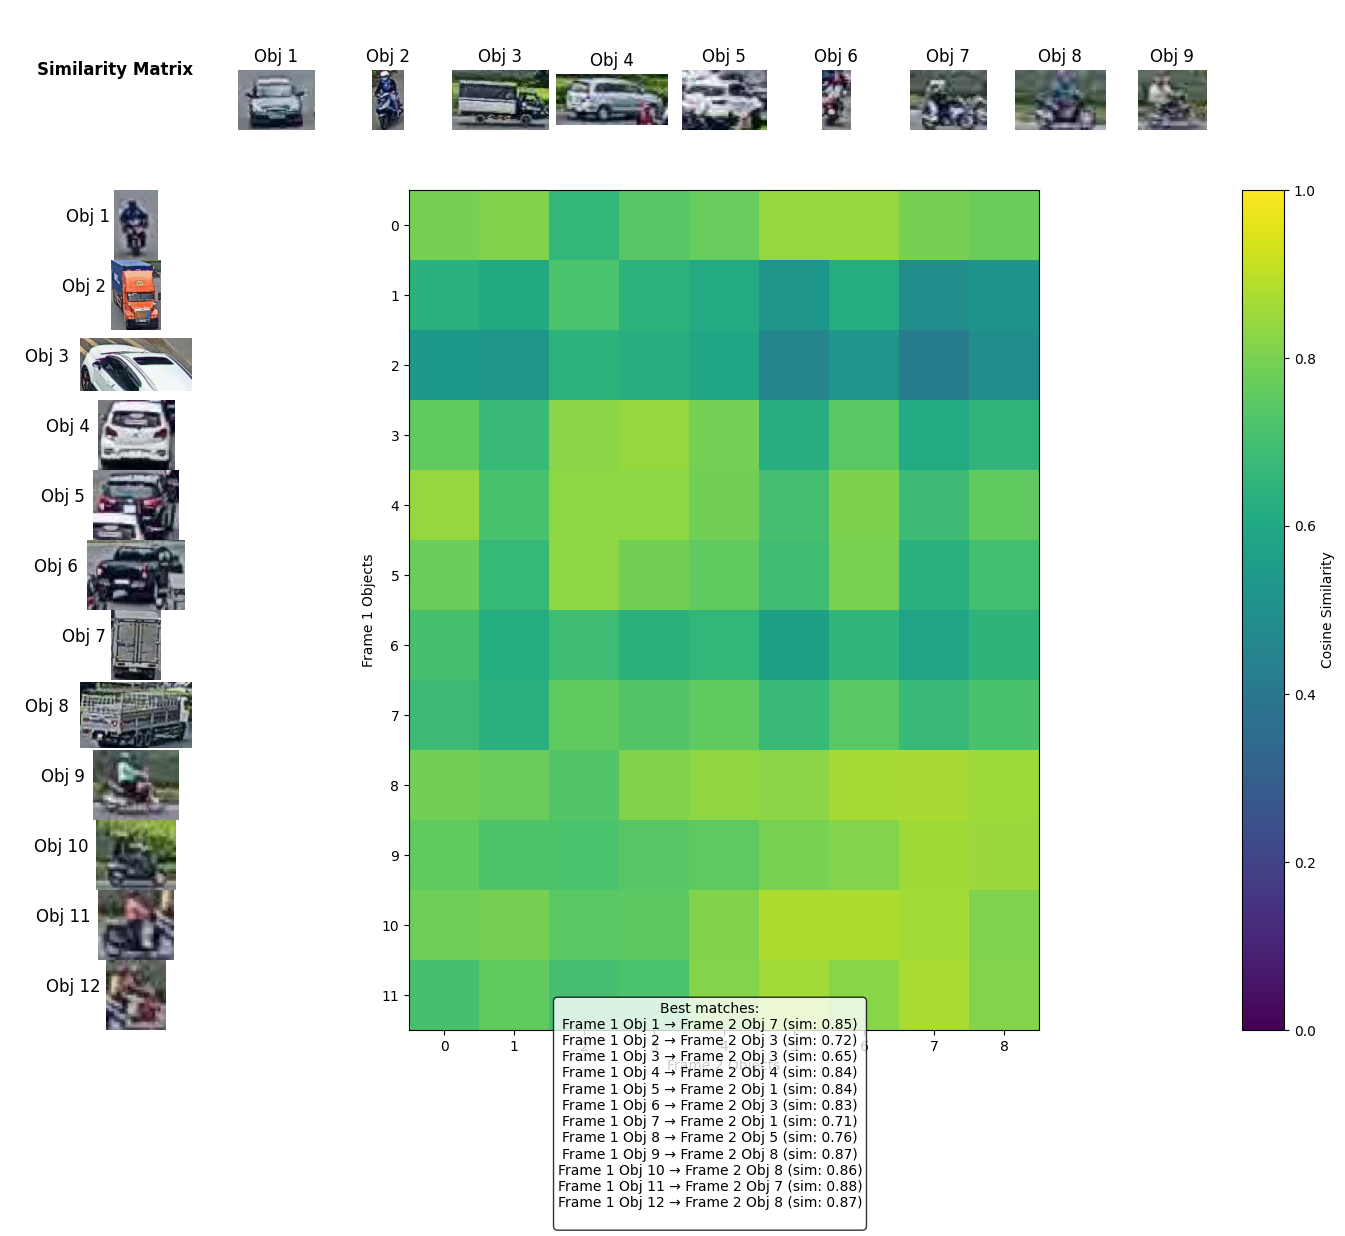

In [168]:
# similarity_matrix, f1_objs, f2_objs = track_objects_between_frames(instance_imgs_frames[0], instance_imgs_frames[1])
#     # Visualize the results
# _ = visualize_similarity_matrix(similarity_matrix, f1_objs, f2_objs)
similarity_matrix = track_and_visualize(instance_imgs_frames[0], instance_imgs_frames[1])

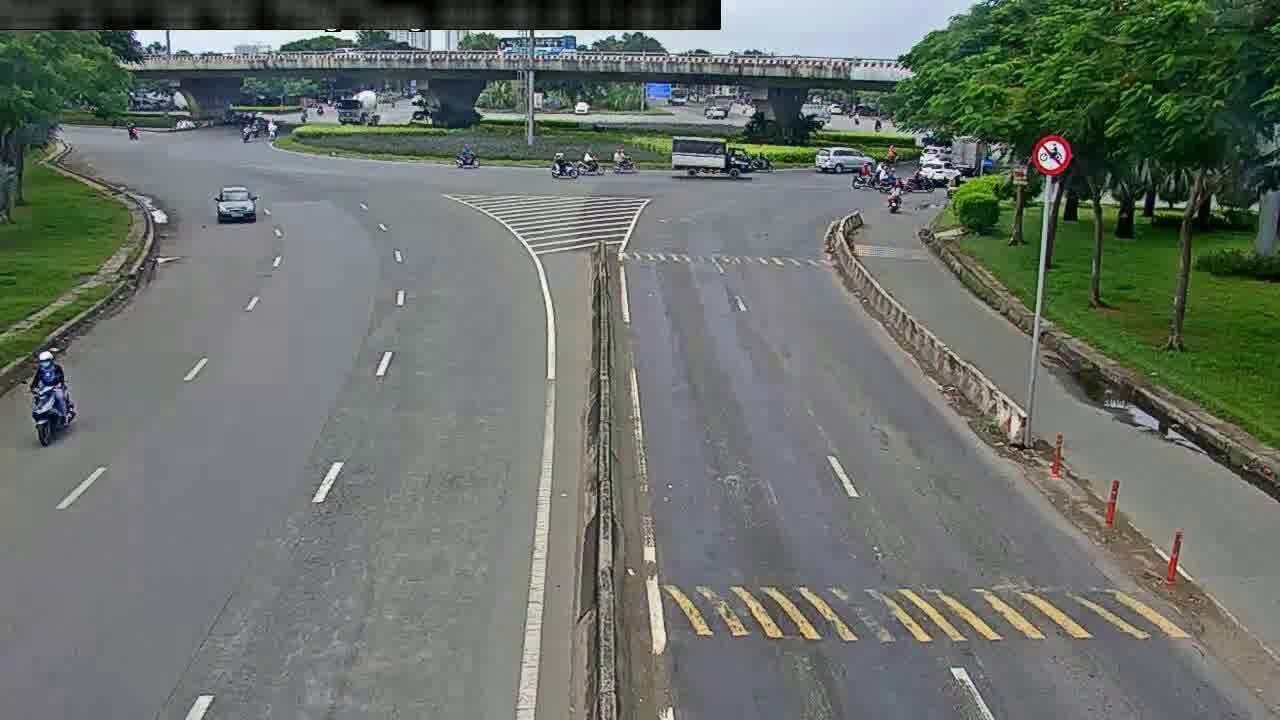

In [171]:
Image.open(image_path[1]).convert('RGB')

In [172]:
import cv2
import os
from pathlib import Path

def create_video_from_images(image_folder, output_video_path, fps=30):
    """
    Create a video from a folder of images sorted by frame ID.
    
    Parameters:
    image_folder (str): Path to the folder containing image frames
    output_video_path (str): Path where the output video will be saved (e.g., 'output.mp4')
    fps (int): Frames per second for the output video (default: 30)
    """
    # Convert to Path object for easier handling
    image_folder = Path(image_folder)
    
    # Get list of image files and sort them
    image_files = [f for f in image_folder.glob('*') if f.suffix in ['.jpg', '.jpeg', '.png']]
    image_files = sorted(image_files, key=lambda x: x.name)  # Sort by filename
    
    if not image_files:
        raise ValueError("No image files found in the specified folder.")
    
    # Read the first image to get dimensions
    first_frame = cv2.imread(str(image_files[0]))
    if first_frame is None:
        raise ValueError(f"Failed to read the first image: {image_files[0]}")
    
    height, width, _ = first_frame.shape
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # Write each image to the video
    for image_path in image_files:
        frame = cv2.imread(str(image_path))
        if frame is None:
            print(f"Warning: Failed to read {image_path}, skipping...")
            continue
        
        # Ensure frame dimensions match
        if frame.shape[:2] != (height, width):
            frame = cv2.resize(frame, (width, height))
        
        video_writer.write(frame)
        print(f"Added frame: {image_path.name}")
    
    # Release the video writer
    video_writer.release()
    print(f"Video saved as {output_video_path}")

In [174]:
create_video_from_images("HCM_traffic/tracking_data/images/cam_01", "cam_01.mp4", fps=10)

Added frame: cam_01_000000.jpg
Added frame: cam_01_000001.jpg
Added frame: cam_01_000002.jpg
Added frame: cam_01_000003.jpg
Added frame: cam_01_000004.jpg
Added frame: cam_01_000005.jpg
Added frame: cam_01_000006.jpg
Added frame: cam_01_000007.jpg
Added frame: cam_01_000008.jpg
Added frame: cam_01_000009.jpg
Added frame: cam_01_000010.jpg
Added frame: cam_01_000011.jpg
Added frame: cam_01_000012.jpg
Added frame: cam_01_000013.jpg
Added frame: cam_01_000014.jpg
Added frame: cam_01_000015.jpg
Added frame: cam_01_000016.jpg
Added frame: cam_01_000017.jpg
Added frame: cam_01_000018.jpg
Added frame: cam_01_000019.jpg
Added frame: cam_01_000020.jpg
Added frame: cam_01_000021.jpg
Added frame: cam_01_000022.jpg
Added frame: cam_01_000023.jpg
Added frame: cam_01_000024.jpg
Added frame: cam_01_000025.jpg
Added frame: cam_01_000026.jpg
Added frame: cam_01_000027.jpg
Added frame: cam_01_000028.jpg
Added frame: cam_01_000029.jpg
Added frame: cam_01_000030.jpg
Added frame: cam_01_000031.jpg
Added fr